# Auto-Encoders

In the *dimention_reduction* notebook, we previously explored various dimensionality reduction techniques, reducing the dataset to 10, 20, and 80 features.  
Here, we will examine how a simple autoencoder and a slightly more complex convolutional autoencoder learn the latent space of our training dataset across these same dimensions. These learned representations will later be used for clustering.

The simple AutoEncoder consists of the following components:
- Encoder:
    - Takes a 28×28 grayscale image (1 color channel) as input.
    - Flattens the image into a one-dimensional array.
    - Uses a Dense layer with ReLU activation to reduce the dimensionality, mapping the data into a smaller latent space.

- Decoder:
    - Receives the embedded latent representation of the original image as input.
    - Expands it back to the original size using a Dense layer with 784 units (28×28 pixels) and Sigmoid activation.
    - Reshapes the output into a 28×28 image to reconstruct the original input.

The Convolutional Autoencoder consists of the following components:
- Encoder:
    - Takes a 28×28 grayscale image (1 color channel) as input.
    - Uses two convolutional layers (with 32 and 64 filters, respectively) to extract features and reduce spatial dimensions using a stride of 2.
    - Flattens the resulting feature maps into a one-dimensional array.
    - Uses a Dense layer with ReLU activation to map the data into a smaller latent space.

- Decoder:
    - Receives the compressed latent representation of the original image as input.
    - Expands it back by first using a Dense layer to project the data into a 7×7×64 tensor.
    - Uses three transposed convolutional layers (Conv2DTranspose) to progressively upsample and reconstruct the original spatial dimensions.
    - The final layer applies a Sigmoid activation to output a 28×28 grayscale image, resembling the original input.

Results:
- After 10 epochs, all models effectively compress images into a smaller space.
- The best-performing model is the Convolutional Autoencoder with a latent space of 80 dimensions, followed closely by the standard Autoencoder with 80 dimensions and the Convolutional Autoencoder with 20 dimensions.
- Model complexity significantly impacts performance in low-dimensional latent spaces, but its influence diminishes as dimensionality increases. However, more complex models require longer training times per epoch and may need larger datasets to converge efficiently.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

import json

import tensorflow as tf
from tensorflow.keras import saving
from tensorflow.keras import datasets as tf_datasets 

2025-02-05 12:21:11.485819: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-05 12:21:11.490893: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-05 12:21:11.504681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738754471.526920   70426 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738754471.533259   70426 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-05 12:21:11.555358: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## Useful Decorators

In [2]:
def keras_load_if_exists(path:Path = None): 
    def decorator(function): 
        def wrapper(*args, **kwargs):
            if path.exists(): 
                res = tf.keras.models.load_model(path)
            else:
                res = function(*args, **kwargs)
                path.parent.mkdir(parents=True, exist_ok=True)
                res.save(path)
            return res
        return wrapper
    return decorator

In [3]:
def pandas_load_if_exists(path: Path): 
    def decorator(function): 
        def wrapper(*args, **kwargs):
            if path.exists(): 
                res = pd.read_csv(path) 
            else:
                res = function(*args, **kwargs)
                path.parent.mkdir(parents=True, exist_ok=True)
                res.to_csv(path, index=False)
            return res
        return wrapper
    return decorator

## Data Preprocessing

In [4]:
def preprocess_images(images):
    normalized_typed_images = (images / 255.0).astype('float32')
    return normalized_typed_images[..., tf.newaxis]  # Expand dimensions

(train_images, _), (_, _) = tf_datasets.fashion_mnist.load_data()
processed_train_images = preprocess_images(train_images)

processed_train_images.shape

(60000, 28, 28, 1)

## Models

In [5]:
class Autoencoder(tf.keras.Model):
    """Autoencoder abstarcted class"""
    
    def __init__(self, latent_dim, history_data=None, **kwargs):
        super().__init__(**kwargs)
        self.latent_dim = latent_dim
        self.history_data = history_data or {}

        self.encoder = None  
        self.decoder = None  

    def call(self, x):
        latent = self.encoder(x) 
        reconstructed = self.decoder(latent) 
        return reconstructed

    ### The following is usefull for history loading
    def fit(self, *args, **kwargs):
        history = super().fit(*args, **kwargs)
        self.history_data = history.history 
        return history

    def get_config(self):
        config = super().get_config()
        config.update({
            "latent_dim": self.latent_dim,
            "history_data": json.dumps(self.history_data) 
        })
        return config

    @classmethod
    def from_config(cls, config):
        config["history_data"] = json.loads(config.get("history_data", "{}")) 
        return cls(**config)


In [6]:
@saving.register_keras_serializable()
class AE(Autoencoder):
    """A simple Autoencoder."""
    
    def __init__(self, latent_dim, history_data=None, **kwargs):
        super().__init__(latent_dim, history_data, **kwargs)
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(shape=(28, 28, 1)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim, activation='relu'),
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(shape=(latent_dim,)),
            tf.keras.layers.Dense(784, activation='sigmoid'),
            tf.keras.layers.Reshape((28, 28, 1))
        ])

In [7]:
@saving.register_keras_serializable()
class CAE(Autoencoder):
    """
        Convolutional Autoencoder (CAE) inspired from tensorflow Convolutional Variational Autoencoder Guide
        https://www.tensorflow.org/tutorials/generative/cvae
    """

    def __init__(self, latent_dim, history_data=None, **kwargs):
        super().__init__(latent_dim, history_data, **kwargs)

        # Define Encoder: Convolutional layers reduce input size
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding="same", activation="relu"),
            tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu"),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim, activation="relu")
        ])

        # Define Decoder: Transposed convolutions reconstruct the input
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(shape=(latent_dim,)),
            tf.keras.layers.Dense(7 * 7 * 64, activation="relu"),
            tf.keras.layers.Reshape((7, 7, 64)),
            tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu"),
            tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation="relu"),
            tf.keras.layers.Conv2DTranspose(1, kernel_size=3, strides=1, padding="same", activation="sigmoid")
        ])

## Auto Encoder Training

In [8]:
METRICS = ['accuracy', 'mse']
LOSS =  'mean_squared_error' # 'binary_crossentropy'
OPTIMIZER = 'adam'

EPOCHS = 10
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.1

def compile_train_model(model, x_train): 
    model.compile(
        optimizer=OPTIMIZER, 
        loss=LOSS, 
        metrics=METRICS
    )
    model.fit(
          x=x_train
        , y=x_train
        , epochs=EPOCHS
        , shuffle=True
        , batch_size=BATCH_SIZE
        , validation_split=VALIDATION_SPLIT
    )

def ae_fit_transform(
    latent_dim:int, x_train
) -> tuple[AE, pd.DataFrame]:
    
    @keras_load_if_exists(Path(f'model_selection/models/ae_{latent_dim}.keras'))
    def ae_fit(latent_dim, x_train): 
        ae = AE(latent_dim)
        compile_train_model(ae, x_train)
        return ae
    
    @pandas_load_if_exists(path=Path(f'model_selection/data/X_ae_{latent_dim}.csv'))
    def ae_transform(ae: AE, x_train): 
        embeddings = pd.DataFrame(
            ae.encoder.predict(x_train)
            , columns = [f'Component_{i}' for i in range(latent_dim)]
        )
        return embeddings
    
    ae = ae_fit(latent_dim, x_train)
    embeddings = ae_transform(ae, x_train)

    return ae, embeddings

def cae_fit_transform(
    latent_dim:int, x_train
) -> tuple[CAE, pd.DataFrame]:
    
    @keras_load_if_exists(Path(f'model_selection/models/cae_{latent_dim}.keras'))
    def cae_fit(latent_dim, x_train): 
        cae = CAE(latent_dim)
        compile_train_model(cae, x_train)
        return cae
    
    @pandas_load_if_exists(path=Path(f'model_selection/data/X_cae_{latent_dim}.csv'))
    def cae_transform(cae: CAE, x_train): 
        embeddings = pd.DataFrame(
            cae.encoder.predict(x_train)
            , columns = [f'Component_{i}' for i in range(latent_dim)]
        )
        return embeddings
    
    cae = cae_fit(latent_dim, x_train)
    embeddings = cae_transform(cae, x_train)

    return cae, embeddings

In [9]:
ae_10, X_ae_10 = ae_fit_transform(10, processed_train_images)
ae_20, X_ae_20 = ae_fit_transform(20, processed_train_images)
ae_80, X_ae_80 = ae_fit_transform(80, processed_train_images)

2025-02-05 12:21:15.718998: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [10]:
cae_10, X_cae_10 = cae_fit_transform(10, processed_train_images)
cae_20, X_cae_20 = cae_fit_transform(20, processed_train_images)
cae_80, X_cae_80 = cae_fit_transform(80, processed_train_images)

## Training Results

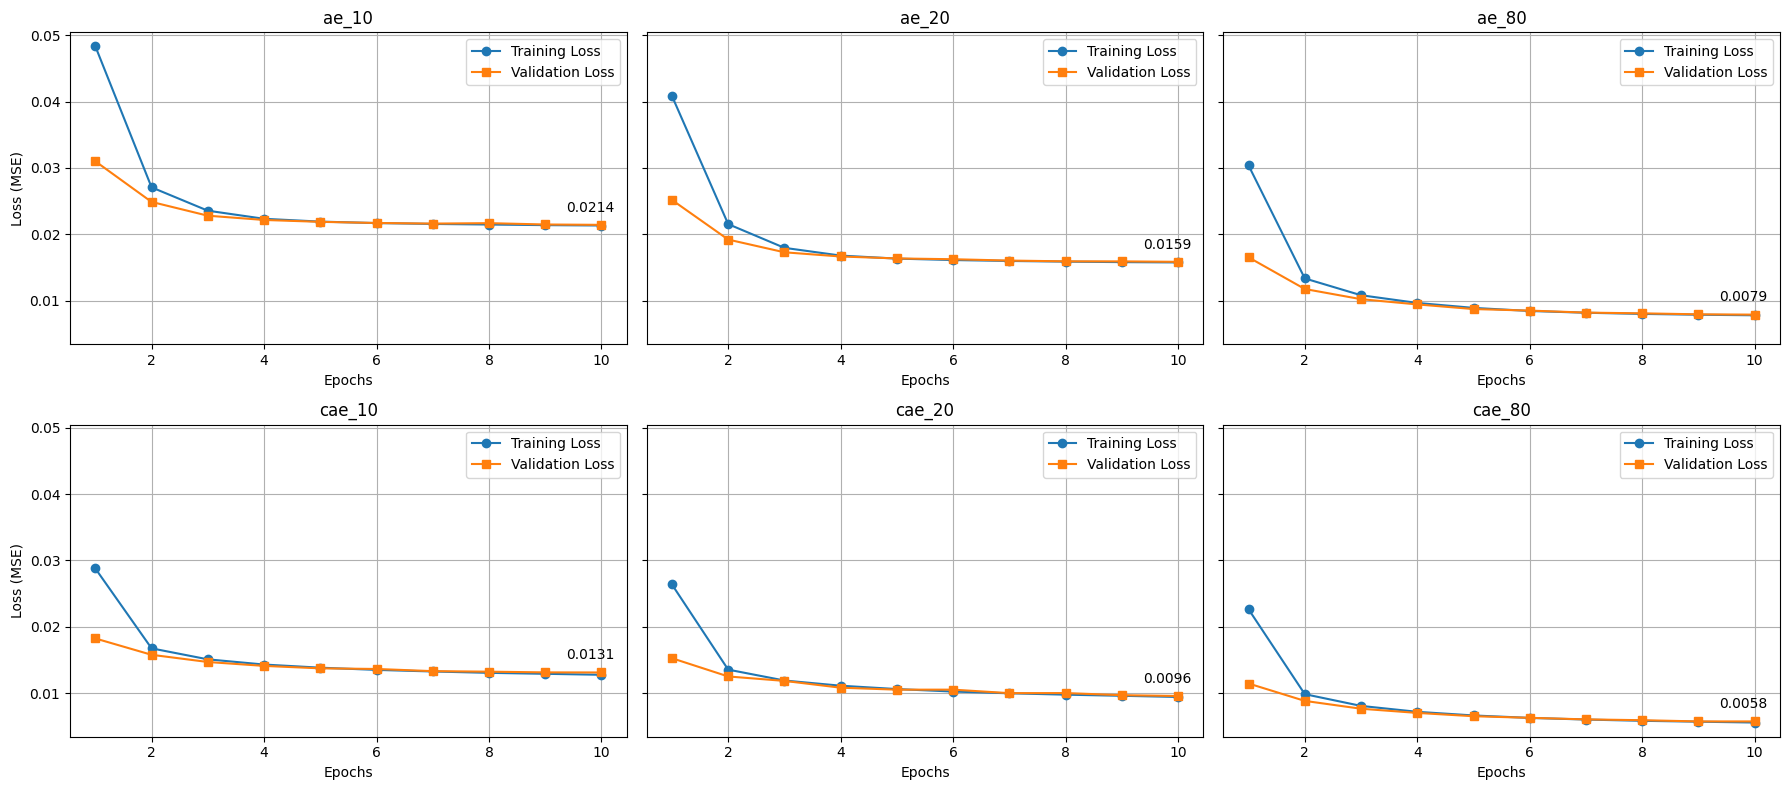

In [11]:
ae_models = {'ae_10': ae_10.history_data, 'ae_20': ae_20.history_data, 'ae_80': ae_80.history_data}
cae_models = {'cae_10': cae_10.history_data, 'cae_20': cae_20.history_data, 'cae_80': cae_80.history_data}

ae_models = {'ae_10': ae_10.history_data, 'ae_20': ae_20.history_data, 'ae_80': ae_80.history_data}
cae_models = {'cae_10': cae_10.history_data, 'cae_20': cae_20.history_data, 'cae_80': cae_80.history_data}

# Plot
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharey=True)
padding_y = 0.002
padding_x = -0.2

# First row: AE models
for ax, (name, history) in zip(axes[0], ae_models.items()):
    epochs = range(1, len(history['loss']) + 1)
    ax.plot(epochs, history['loss'], label='Training Loss', marker='o')
    ax.plot(epochs, history['val_loss'], label='Validation Loss', marker='s')

    last_val_loss = history['val_loss'][-1]
    ax.text(epochs[-1] + padding_x, last_val_loss + padding_y, f'{last_val_loss:.4f}', ha='center') # verticalalignment='bottom'

    ax.set_xlabel('Epochs')
    ax.set_title(name)
    ax.legend()
    ax.grid()

# Second row: CAE models
for ax, (name, history) in zip(axes[1], cae_models.items()):
    epochs = range(1, len(history['loss']) + 1)
    ax.plot(epochs, history['loss'], label='Training Loss', marker='o')
    ax.plot(epochs, history['val_loss'], label='Validation Loss', marker='s')

    last_val_loss = history['val_loss'][-1]
    ax.text(epochs[-1] + padding_x, last_val_loss + padding_y, f'{last_val_loss:.4f}', ha='center') # verticalalignment='bottom'

    ax.set_xlabel('Epochs')
    ax.set_title(name)
    ax.legend()
    ax.grid()

# Set ylabel only for first column
axes[0, 0].set_ylabel('Loss (MSE)')
axes[1, 0].set_ylabel('Loss (MSE)')

fig.tight_layout()
plt.show()


After 10 epochs, all models demonstrate strong capability in compressing images into a smaller space.
The best-performing model is cae_80, closely followed by ae_80 and cae_20.
These graphs highlight the significant impact of model complexity on performance when embedding in small spaces, while its effect diminishes in higher-dimensional spaces. However, a more complex model increases training time per epoch and sometimes requires a larger volume of data to converge.